# Tuning models optimization

##### Modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import dill
import datetime
import math
import itertools

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels.api

from sklearn import model_selection
from sklearn.metrics import mean_squared_error, classification_report, roc_curve, auc, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

##### Define workspace

In [2]:
os.chdir('C:\\Users\\Megaport\\Desktop\\jupyterNotebook')
os.getcwd()

'C:\\Users\\Megaport\\Desktop\\jupyterNotebook'

##### Import

In [3]:
# dfPoolMLCCA = pd.read_pickle('D:\\jupyterDatasets\\20221031_table_dfPoolMLCCA.csv')
feature_matrix = pd.read_pickle('D:\\jupyterDatasets\\20221112_table_feature_matrix.csv')
target = pd.read_pickle('D:\\jupyterDatasets\\20221119_table_target.csv')

# print(dfPoolMLCCA.shape)
print(feature_matrix.shape)
print(target.shape)

(836553, 70)
(836553,)


In [4]:
feature_matrix.columns

Index(['choc_cote', 'ageMeanConductors', 'nbVeh', 'prof_2.0', 'prof_3.0',
       'planGrp_1.0', 'surf_2.0', 'surf_8.0', 'atm_2.0', 'atm_3.0', 'atm_5.0',
       'atm_7.0', 'atm_8.0', 'vospGrp_1.0', 'catv_EPD_exist_1',
       'catv_PL_exist_1', 'trajet_coursesPromenade_conductor_1',
       'sexe_male_conductor_1', 'sexe_female_conductor_1',
       'intGrp_Croisement circulaire', 'intGrp_Croisement de deux routes',
       'intGrp_Hors intersection', 'intGrp_Passage à niveau',
       'catv_train_exist_1', 'infra_3.0', 'infra_5.0', 'infra_7.0',
       'infra_9.0', 'catr_2.0', 'catr_3.0', 'catr_4.0', 'catr_9.0',
       'hourGrp_nuit', 'lum_2.0', 'lum_3.0', 'lum_5.0', 'circ_2.0', 'circ_3.0',
       'circ_4.0', 'nbvGrp_1', 'nbvGrp_2', 'nbvGrp_3', 'nbvGrp_4+',
       'catv_2_roues_exist_1', 'col_2.0', 'col_3.0', 'col_4.0', 'col_5.0',
       'col_6.0', 'col_7.0', 'obsGrp_Pas d'Obstacle', 'situ_2.0', 'situ_3.0',
       'situ_4.0', 'situ_6.0', 'situ_8.0', 'populationGrp_Grande Ville',
       'popu

##### Splitting into train/test sets

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_matrix, target, test_size=0.2, random_state=1)

In [6]:
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

In [7]:
print('Prevalence y train:', round(sum(y_train) / len(y_train), 4))
print('Prevalence y test:', round(sum(y_test) / len(y_test), 4))

Prevalence y train: 0.4234
Prevalence y test: 0.423


### Models

### 1- XGBoost
**Les paramètres généraux**  
- booster : Le type de booster utilisé (par défaut gbtree).  
- nthread : Le nombre de coeurs à utiliser pour le calcul parallèle (par défaut tous les coeurs disponibles sont utilisés).  

**Les paramètres du booster (on se limitera ici au cas des arbres)**  
- num_boost_round : Le nombre maximum d'itérations/d'arbres construits (vaut 100 par défaut).  
- learning_rate : Contrôle le 'taux d’apprentissage'. A chaque étape de boosting, on introduit une constante dans la formule de mise à jour des modèles. Elle réduit le poids obtenu par rapport aux performances pour prévenir l'overfitting. Une valeur faible entraîne un modèle plus robuste au sur-apprentissage, mais un calcul et une convergence plus lents. Pensez à augmenter le nombre d'arbres lorsque learning_rate est faible (vaut 0.3 par défaut, et doit être compris entre 0 et 1).  
- min_split_loss : Réduction de perte minimale requise pour effectuer une partition supplémentaire sur un nœud de l'arbre. Plus il est grand, plus l'algorithme sera conservateur.  
- max_depth : Contrôle la profondeur des arbres. Plus les arbres sont profonds, plus le modèle est complèxe et plus grandes sont les chances d'overfitting (vaut 6 par défaut).  
- min_child_weight : Critère d'arrêt relatif à la taille minimum du nombre d'observation dans un noeud (vaut 1 par défaut).  
- subsample : Permet d'utiliser un sous-échantillon du dataset d'entraînement pour chaque arbre (vaut 1 par défaut, pas de sous-échantillonnage ; et doit être compris entre 0 et 1).  
- colsample_bytree : Permet d'utiliser un certain nombre de variables parmi celles d'origine (vaut 1 par défaut, toutes les variables sont séléctionnées ; et doit être compris entre 0 et 1).  
- reg_lambda et reg_alpha : contrôlent respectivement la régularisation L1 et L2 sur les poids (équivalent aux régression Ridge et Lasso).  

- Fonction objectif à utiliser
    - binary:logistic pour la classification binaire. Retourne les probabilités pour chaque classe.
    - reg:linear pour la régression.
    - multi:softmax pour la classification multiple en utilisant la fonction softmax. Retourne les labels prédits.
    - multi:softprob pour la classification multiple en utilisant la fonction softmax. Retourne les probabilités pour chaque classe.
- eval_metric : Métrique d'évaluation (par défaut l'erreur de prédiction pour la classification, le RMSE pour la régression).
Les métriques disponibles sont : mae (Mean Absolute Error), Logloss, AUC, RMSE, error mologloss, etc...
- early_stopping_rounds : pour arrêter l'apprentissage quand l'évaluation sur l'ensemble de test ne s'améliore plus durant un certain nombre d'itérations. L'erreur de validation doit diminuer au moins tous les early_stopping_rounds pour continuer l'entraînement.

##### Initial model

In [175]:
### Initiating parameters for basic XGBoost
# params = {'objective' : 'binary:logistic', 
#           'booster' : 'gbtree', 
#           'learning_rate' : 1,
#           'eval_metric' : 'AUC'}
params = [
    ('objective', 'binary:logistic'),
    ('max_depth', 6),
    ('eval_metric', 'auc'),
    ('early_stopping_rounds', 10)
]

### Basic XGBoost without tuning
clf_xgb = xgb.train(params=params, dtrain=train, 
                    num_boost_round=50, 
                    evals=[(train, 'train'), (test, 'eval')])

[23:18:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.75326	eval-auc:0.75193
[1]	train-auc:0.75916	eval-auc:0.75808
[2]	train-auc:0.76525	eval-auc:0.76358
[3]	train-auc:0.76890	eval-auc:0.76710
[4]	train-auc:0.77253	eval-auc:0.77078
[5]	train-auc:0.77496	eval-auc:0.77323
[6]	train-auc:0.77653	eval-auc:0.77470
[7]	train-auc:0.77926	eval-auc:0.77725
[8]	train-auc:0.78084	eval-auc:0.77874
[9]	train-auc:0.78223	eval-auc:0.78000
[10]	train-auc:0.78386	eval-auc:0.78153
[11]	train-auc:0.78490	eval-auc:0.78252
[12]	train-auc:0.78554	eval-auc:0.78300
[13]	train-auc:0.78610	eval-auc:0.78349
[14]	train-auc:0.786

In [176]:
xgb_pred_train = clf_xgb.predict(train)
xgb_pred_test = clf_xgb.predict(test)

In [177]:
### Export of prediction of initial XGBoost
# pd.DataFrame(xgb_pred_train).to_pickle('D:\\jupyterDatasets\\20221121_xgb_pred_train.csv')
# pd.DataFrame(xgb_pred_test).to_pickle('D:\\jupyterDatasets\\20221121_xgb_pred_test.csv')

In [20]:
xgb_pred_train_bin = np.where(xgb_pred_train>=0.5, 1, 0)
xgb_pred_test_bin = np.where(xgb_pred_test>=0.5, 1, 0)

In [21]:
pd.crosstab(y_train, xgb_pred_train_bin, colnames=['xgb_pred_train'], normalize=True)

xgb_pred_train,0,1
gravGrp_2_34,,
0,0.488016,0.088584
1,0.171464,0.251936


In [22]:
print(classification_report(y_train, xgb_pred_train_bin))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79    385885
           1       0.74      0.60      0.66    283357

    accuracy                           0.74    669242
   macro avg       0.74      0.72      0.72    669242
weighted avg       0.74      0.74      0.73    669242



In [23]:
pd.crosstab(y_test, xgb_pred_test_bin, colnames=['xgb_pred_test'], normalize=True)

xgb_pred_test,0,1
gravGrp_2_34,,
0,0.486860,0.090126
1,0.173294,0.249721


In [24]:
print(classification_report(y_test, xgb_pred_test_bin))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     96536
           1       0.73      0.59      0.65     70775

    accuracy                           0.74    167311
   macro avg       0.74      0.72      0.72    167311
weighted avg       0.74      0.74      0.73    167311



In [25]:
# AUC train
fpr_xgb_train, tpr_xgb_train, seuils = roc_curve(y_train, xgb_pred_train, pos_label=1)
roc_auc_xgb_train = auc(fpr_xgb_train, tpr_xgb_train)
# AUC test
fpr_xgb_test, tpr_xgb_test, seuils = roc_curve(y_test, xgb_pred_test, pos_label=1)
roc_auc_xgb_test = auc(fpr_xgb_test, tpr_xgb_test)

print(roc_auc_xgb_train)
print(roc_auc_xgb_test)

0.7964184317461727
0.7908759210649992


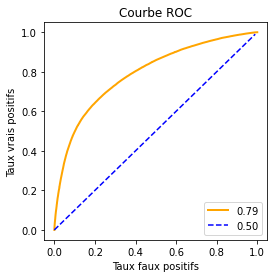

In [26]:
# ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr_xgb_test, tpr_xgb_test, color='orange', lw=2, label=round(roc_auc_xgb_test, 2))
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'b--', label='0.50')
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right');

##### Tuning

In [109]:
##### Initiating basic XGBoost
estimator = XGBClassifier(
    objective= 'binary:logistic',
    num_boost_round=50,
    seed=1
)

parameters = {
    'max_depth': [4, 6],
    'gamma': [0, 0.25, 1],
    'reg_lambda': [0, 1.0, 10.0],
}

#     'learning_rate': [0.1, 0.05, 0.03, 0.01]
        
kf = KFold(n_splits=5, shuffle=True, random_state=1)

### GridSearchCV
grid_search_1 = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = kf,
    verbose=1,
    return_train_score=True
)

grid_search_1.fit(X_train, y_train)

print(grid_search_1.best_params_)
### Best parameters: {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 10.0}
### Decision: we keep gamma=0.25, we go beyond max_depth=6 and beyond reg_lambda=10

{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 10.0}


In [108]:
dfGridSearchCV_1 = pd.DataFrame(grid_search_1.cv_results_)[['params', 'rank_test_score', 'mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']]
dfGridSearchCV_1.sort_values('rank_test_score')
### Max_depth=6 always was better in test cases
### 3 best models had reg_lambda=10.0
### We can still question the gamma value

,params,rank_test_score,mean_test_score,mean_train_score,std_test_score,std_train_score
11,"{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...",1,0.793123,0.801680,0.000469,0.000341
17,"{'gamma': 1, 'max_depth': 6, 'reg_lambda': 10.0}",2,0.793119,0.801801,0.000368,0.000282
5,"{'gamma': 0, 'max_depth': 6, 'reg_lambda': 10.0}",3,0.793097,0.801632,0.000421,0.000239
16,"{'gamma': 1, 'max_depth': 6, 'reg_lambda': 1.0}",4,0.792804,0.803157,0.000498,0.000232
10,"{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...",5,0.792759,0.803021,0.000407,0.000134
4,"{'gamma': 0, 'max_depth': 6, 'reg_lambda': 1.0}",6,0.792743,0.803138,0.000390,0.000298
3,"{'gamma': 0, 'max_depth': 6, 'reg_lambda': 0}",7,0.792576,0.803626,0.000510,0.000209
9,"{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 0}",8,0.792556,0.803594,0.000393,0.000173
15,"{'gamma': 1, 'max_depth': 6, 'reg_lambda': 0}",9,0.792462,0.803626,0.000529,0.000228
1,"{'gamma': 0, 'max_depth': 4, 'reg_lambda': 1.0}",10,0.790935,0.793601,0.000447,0.000253


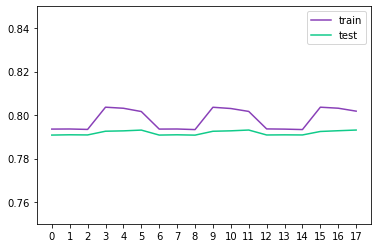

In [133]:
##### Plot GridSearchCV1 train vs test
results = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

train_scores = grid_search_1.cv_results_['mean_train_score']
test_scores = grid_search_1.cv_results_['mean_test_score']

plt.plot(train_scores, label='train', color='#8940B8')
plt.plot(test_scores, label='test', color='#10CB8A')
plt.xticks(range(18))
plt.ylim((0.75, 0.85))
plt.legend(loc='best')
plt.show()

In [131]:
dfGridSearchCV_1.params

0         {'gamma': 0, 'max_depth': 4, 'reg_lambda': 0}
1       {'gamma': 0, 'max_depth': 4, 'reg_lambda': 1.0}
2      {'gamma': 0, 'max_depth': 4, 'reg_lambda': 10.0}
3         {'gamma': 0, 'max_depth': 6, 'reg_lambda': 0}
4       {'gamma': 0, 'max_depth': 6, 'reg_lambda': 1.0}
5      {'gamma': 0, 'max_depth': 6, 'reg_lambda': 10.0}
6      {'gamma': 0.25, 'max_depth': 4, 'reg_lambda': 0}
7     {'gamma': 0.25, 'max_depth': 4, 'reg_lambda': ...
8     {'gamma': 0.25, 'max_depth': 4, 'reg_lambda': ...
9      {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 0}
10    {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...
11    {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...
12        {'gamma': 1, 'max_depth': 4, 'reg_lambda': 0}
13      {'gamma': 1, 'max_depth': 4, 'reg_lambda': 1.0}
14     {'gamma': 1, 'max_depth': 4, 'reg_lambda': 10.0}
15        {'gamma': 1, 'max_depth': 6, 'reg_lambda': 0}
16      {'gamma': 1, 'max_depth': 6, 'reg_lambda': 1.0}
17     {'gamma': 1, 'max_depth': 6, 'reg_lambda'

In [142]:
##### GridSearchCV 2nd step
parameters = {
    'max_depth': [4, 6, 8, 10],
    'gamma': [0.25],
    'reg_lambda': [10.0]
}

kf = KFold(n_splits=5, shuffle=True, random_state=1)

### GridSearchCV
grid_search_2 = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = kf,
    verbose=1,
    return_train_score=True
)

grid_search_2.fit(X_train, y_train)

print(grid_search_2.best_params_)
### Best parameters: {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 10.0}
### Decision: we keep gamma=0.25, we go beyond max_depth=6 and beyond reg_lambda=10

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[22:43:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': 10.0}


In [143]:
dfGridSearchCV_2 = pd.DataFrame(grid_search_2.cv_results_)[['params', 'rank_test_score', 'mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']]
dfGridSearchCV_2.sort_values('rank_test_score')
### We need either 4/6 max depth or regularization to avoid overfitting

,params,rank_test_score,mean_test_score,mean_train_score,std_test_score,std_train_score
1,"{'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...",1,0.793123,0.801680,0.000469,0.000341
2,"{'gamma': 0.25, 'max_depth': 8, 'reg_lambda': ...",2,0.792827,0.813836,0.000736,0.000813
3,"{'gamma': 0.25, 'max_depth': 10, 'reg_lambda':...",3,0.791368,0.832448,0.000637,0.001696
0,"{'gamma': 0.25, 'max_depth': 4, 'reg_lambda': ...",4,0.790777,0.793324,0.000464,0.000257


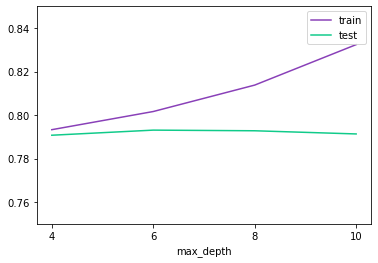

In [153]:
##### Plot GridSearchCV2 train vs test
results = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

train_scores = grid_search_2.cv_results_['mean_train_score']
test_scores = grid_search_2.cv_results_['mean_test_score']

plt.plot(train_scores, label='train', color='#8940B8')
plt.plot(test_scores, label='test', color='#10CB8A')
plt.xticks([0, 1, 2, 3], [4, 6, 8, 10])
plt.xlabel('max_depth')
plt.ylim((0.75, 0.85))
plt.legend(loc='best')
plt.show()

In [155]:
dfGridSearchCV_2.params

0    {'gamma': 0.25, 'max_depth': 4, 'reg_lambda': ...
1    {'gamma': 0.25, 'max_depth': 6, 'reg_lambda': ...
2    {'gamma': 0.25, 'max_depth': 8, 'reg_lambda': ...
3    {'gamma': 0.25, 'max_depth': 10, 'reg_lambda':...
Name: params, dtype: object

In [168]:
##### Launching optimal XGBoost
params = [
    ('objective', 'binary:logistic'),
    ('max_depth', 6),
    ('gamma', 0.25),
    ('reg_lambda', 10.0),
    ('eval_metric', 'auc'),
    ('early_stopping_rounds', 10)
]

optimal_xgb = xgb.train(params=params, dtrain=train, 
                    num_boost_round=100, 
                    evals=[(train, 'train'), (test, 'eval')])

[23:16:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.75320	eval-auc:0.75182
[1]	train-auc:0.75912	eval-auc:0.75812
[2]	train-auc:0.76522	eval-auc:0.76353
[3]	train-auc:0.76888	eval-auc:0.76701
[4]	train-auc:0.77247	eval-auc:0.77060
[5]	train-auc:0.77460	eval-auc:0.77285
[6]	train-auc:0.77633	eval-auc:0.77447
[7]	train-auc:0.77925	eval-auc:0.77717
[8]	train-auc:0.78059	eval-auc:0.77839
[9]	train-auc:0.78228	eval-auc:0.78005
[10]	train-auc:0.78332	eval-auc:0.78101
[11]	train-auc:0.78419	eval-auc:0.78176
[12]	train-auc:0.78527	eval-auc:0.78278
[13]	train-auc:0.78600	eval-auc:0.78344
[14]	train-auc:0.786

In [172]:
### Prediction values of optimal XGBoost
xgb_opti_pred_train = optimal_xgb.predict(train)
xgb_opti_pred_test = optimal_xgb.predict(test)

In [174]:
### Export of prediction of optimal XGBoost
# pd.DataFrame(xgb_opti_pred_train).to_pickle('D:\\jupyterDatasets\\20221121_xgb_opti_pred_train.csv')
# pd.DataFrame(xgb_opti_pred_test).to_pickle('D:\\jupyterDatasets\\20221121_xgb_opti_pred_test.csv')

In [141]:
scores = grid_search_1.cv_results_['mean_test_score'].reshape(3, 3, 2)
scores

array([0.7908058 , 0.79093521, 0.79086679, 0.79257628, 0.792743  ,
       0.79309697, 0.79080549, 0.79093488, 0.79077747, 0.79255641,
       0.79275916, 0.79312331, 0.79084858, 0.79091142, 0.79085617,
       0.79246204, 0.79280428, 0.79311852])

In [ ]:
conda install graphviz python-graphviz

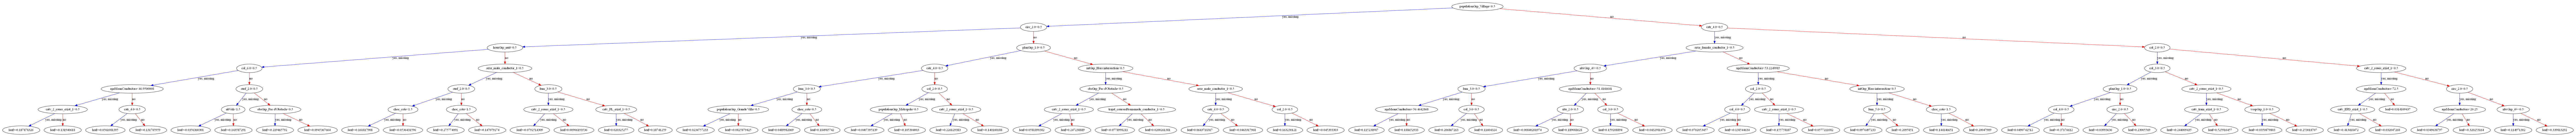

<Figure size 432x288 with 0 Axes>

In [102]:
fig, ax = plt.subplots(figsize=(200, 200))
xgb.plot_tree(clf_xgb, num_trees=4, ax=ax, 
              yes_color='#00cc00', no_color='#FF000', 
              condition_node_params={'shape': 'box', 'style': 'solid'})
plt.show()
#plt.savefig('D:\\jupyterDatasets\\xgboost_tree_graph.png')
#plt.savefig("D:\\jupyterDatasets\\xgboost_tree_graph.pdf")

In [44]:
grid_search_1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_boost_round=50, num_parallel_tree=1,
              predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
grid_search_1.cv_results_

{'mean_fit_time': array([ 61.15931115,  91.69897041, 107.89943595]),
 'std_fit_time': array([4.105348  , 2.87142338, 6.92909419]),
 'mean_score_time': array([0.761868  , 0.74055333, 0.78098564]),
 'std_score_time': array([0.03431526, 0.01597117, 0.09902515]),
 'param_max_depth': masked_array(data=[2, 3, 4],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}],
 'split0_test_score': array([0.78250581, 0.78760482, 0.79023297]),
 'split1_test_score': array([0.78419678, 0.78953565, 0.79287195]),
 'split2_test_score': array([0.78079168, 0.78614412, 0.78952315]),
 'split3_test_score': array([0.78241267, 0.787517  , 0.79130971]),
 'split4_test_score': array([0.7812303 , 0.78708282, 0.79095375]),
 'mean_test_score': array([0.78222745, 0.78757688, 0.79097831]),
 'std_test_score': array([0.00118708, 0.00110798, 0.00112866]),
 'rank_test_score': array([3, 2, 1])}